In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from pydataset import data
import seaborn as sns
import matplotlib.pyplot as plt 
import acquire as acq
import prepare as prep
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
alpha=0.05



In [2]:
telco=acq.get_telco_data()
telco=prep.prep_telco(telco)
telco=telco.rename(columns={"contract_type_Month-to-month":"no_contract"})


In [3]:
train,validate,test=prep.split_data(telco,'churn')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4225 entries, 5911 to 3586
Data columns (total 58 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   customer_id                             4225 non-null   object 
 1   gender                                  4225 non-null   object 
 2   senior_citizen                          4225 non-null   int64  
 3   partner                                 4225 non-null   object 
 4   dependents                              4225 non-null   object 
 5   tenure                                  4225 non-null   int64  
 6   phone_service                           4225 non-null   object 
 7   multiple_lines                          4225 non-null   object 
 8   online_security                         4225 non-null   object 
 9   online_backup                           4225 non-null   object 
 10  device_protection                       4225 non-null   o

In [4]:
#help me create visualiztion for all x,y variables
def create_barplot(data, x, y,title):
    sns.barplot(data=data, x=x, y=y)
    plt.title(title)

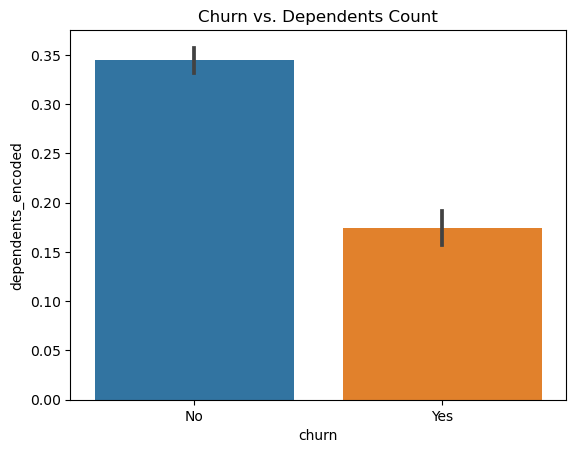

In [5]:
create_barplot(telco,'churn','dependents_encoded', "Churn vs. Dependents Count")

In [6]:
def chi_square_test(observed, alpha=0.05):
    chi2, p, dof, expected = stats.chi2_contingency(observed)
    print("Observed Contingency Table:")
    print(observed)
    print("Expected Contingency Table:")
    print(expected)
    print("Chi-Square Test Statistic:")
    print(chi2)
    print("p-value:")
    print(p)
    if p < alpha:
        print('We reject the null hypothesis.')
    else:
        print('We fail to reject the null hypothesis.')
   
    

In [7]:
observed=pd.crosstab(telco.churn,telco.no_contract)

In [8]:
chi_square_test(observed)

Observed Contingency Table:
no_contract     0     1
churn                  
No           2954  2220
Yes           214  1655
Expected Contingency Table:
[[2327.30824933 2846.69175067]
 [ 840.69175067 1028.30824933]]
Chi-Square Test Statistic:
1153.971661109348
p-value:
6.147585925548493e-253
We reject the null hypothesis.


In [9]:
def t_test(sample1, sample2):
    """
    Performs a two-sample t-test on the provided samples and returns the t-value and p-value.

    Parameters:
    sample1 (array-like): First sample data
    sample2 (array-like): Second sample data

    Returns:
    t_value (float): The calculated t-value from the t-test
    p_value (float): The calculated p-value from the t-test
    """
    # Convert samples to numpy arrays
    sample1 = np.array(sample1)
    sample2 = np.array(sample2)

    # Calculate t-value and p-value using scipy's ttest_ind function
    t_value, p_value = ttest_ind(sample1, sample2)

    return t_value, p_value

In [10]:
x_train=telco.select_dtypes(exclude=['object']).drop(columns=['churn_encoded'])
y_train=telco.churn_encoded
x_validate=telco.select_dtypes(exclude=['object']).drop(columns=['churn_encoded'])
y_validate=telco.churn_encoded
x_test=telco.select_dtypes(exclude=['object']).drop(columns=['churn_encoded'])
y_test=telco.churn_encoded

In [11]:
def fit_DT_random_features(df, target_col, n_random_features=0):
    """
    Fits a decision tree model to the input DataFrame `df`, with an additional
    `n_random_features` randomly selected features from the same DataFrame.
    Returns the best model that achieves a score of 79% or higher on the
    specified `target_col` variable.
    """
    X = df.select_dtypes(exclude=['object']).drop(target_col, axis=1)
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    best_score = 0
    best_model = None
    for depth in range(1, 21):
        selected_cols = np.random.choice(X.columns, size=n_random_features, replace=False)
        X_train_with_random = X_train.copy()
        X_test_with_random = X_test.copy()
        for col in selected_cols:
            X_train_with_random[col] = np.random.permutation(X_train_with_random[col].values)
            X_test_with_random[col] = np.random.permutation(X_test_with_random[col].values)
        model = DecisionTreeClassifier(max_depth=depth)
        model.fit(X_train_with_random, y_train)
        score = model.score(X_test_with_random, y_test)
        if score > best_score and score >= 0.79:
            best_score = score
            best_model = model
    return best_model


In [24]:

fit_DT_random_features(telco,'churn_encoded',n_random_features=6)

DecisionTreeClassifier(max_depth=4)

In [13]:
dt=DecisionTreeClassifier(max_depth=4)
dt.fit(x_train,y_train)
dt.score(x_train,y_train)*100,dt.score(x_validate,y_validate)*100

(79.56836575323015, 79.56836575323015)

In [14]:
def fit_knn_random_features(df, target_col, n_random_features=0):
    X = df.select_dtypes(exclude=['object']).drop(target_col, axis=1)
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    best_score = 0
    best_model = None
    for k in range(1, 21):
        selected_cols = np.random.choice(X.columns, size=n_random_features, replace=False)
        X_train_with_random = X_train.copy()
        X_test_with_random = X_test.copy()
        for col in selected_cols:
            X_train_with_random[col] = np.random.permutation(X_train_with_random[col].values)
            X_test_with_random[col] = np.random.permutation(X_test_with_random[col].values)
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train_with_random, y_train)
        score = model.score(X_test_with_random, y_test)
        if score > best_score and score >= 0.79:
            best_score = score
            best_model = model
    return best_model

In [15]:
fit_knn_random_features(telco,'churn_encoded',n_random_features=6)
 

KNeighborsClassifier(n_neighbors=13)

In [16]:
knn13=KNeighborsClassifier(n_neighbors=11)
knn13.fit(x_train,y_train)
knn13.score(x_train,y_train)*100, knn13.score(x_validate,y_validate)*100, knn13.score(x_test,y_test)*100

(81.2011926735766, 81.2011926735766, 81.2011926735766)

In [17]:
lr=LogisticRegression()
lr.fit(x_train,y_train)
lr.score(x_train,y_train)*100

80.47706943064034

In [18]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
import random

def random_logistic_regression(df, target_col, max_features=None):
    # Drop object/string columns
    df = df.select_dtypes(exclude=['object'])

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=[target_col]), df[target_col], test_size=0.2, random_state=123)

    best_score = 0
    best_model = None
    best_cols = None

    # Iterate through randomized combinations of features
    for i in range(100):
        cols = list(X_train.columns)
        random.shuffle(cols)
        if max_features:
            n_features = min(max_features, len(cols))
        else:
            n_features = len(cols)
        selected_cols = cols[:n_features]

        # Select top K features based on correlation with target variable
        selector = SelectKBest(score_func=f_classif, k=n_features)
        selector.fit(X_train[selected_cols], y_train)
        selected_cols = list(X_train[selected_cols].columns[selector.get_support()])

        # Fit logistic regression model
        model = LogisticRegression()
        model.fit(X_train[selected_cols], y_train)
        score = model.score(X_test[selected_cols], y_test)

        # Keep track of best model and selected columns
        if score > best_score and score >= 0.79:
            best_score = score
            best_model = model
            best_cols = selected_cols

    return best_model, best_cols


In [19]:
random_logistic_regression(telco,'churn_encoded',max_features=10)

(LogisticRegression(),
 ['streaming_tv_Yes',
  'multiple_lines_No phone service',
  'tenure',
  'streaming_tv_No internet service',
  'device_protection_No internet service',
  'online_backup_No internet service',
  'device_protection_No',
  'online_security_No',
  'internet_service_type_DSL',
  'contract_type_One year'])

In [20]:
def create_pie_chart(df, column_name,title):
    values = df[column_name].value_counts()
    labels = values.index.tolist()
    sizes = values.tolist()
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title(title)
    plt.show()
    

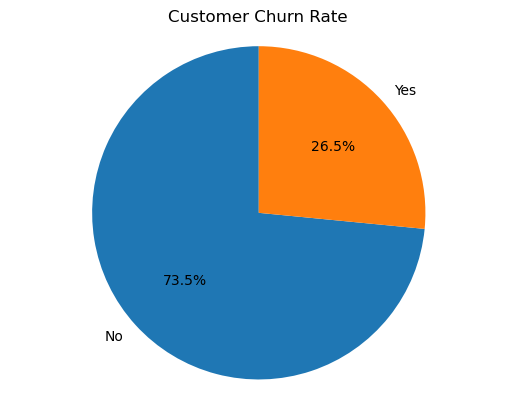

In [21]:
create_pie_chart(telco,'churn','Customer Churn Rate')